# 4IM01 - Skin Lesion Segmentation

In [ ]:
# All imports
from src.utils.display_image import viewimage, viewimgs, view3imgs
import cv2
from tests.test_otsu_simple import display_otsu_simple
from tests.test_otsu_prepro1 import display_otsu_prepro1
from src.preprocessing.dull_razor import dull_razor
from src.postprocessing.post_processing import opening
import skimage.morphology as morph
from src.postprocessing.find_central_component import find_largest_connected_component
from experiments.main_test import table_score, D, D_lvl, table_score_lvl

/Users/louis/Documents/Telecom/2A/IMA/ProjIMA/4im01-skinlesions-giordmainabonniniere/post_processing.py:12: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  struct_element2 = morph.rectangle(2, 5)


## Objective 
This project focuses on the analysis of dermatological images of skin lesions. The goal is to create a pipeline that takes as input a dermatological image presenting a lesion and outputs the binary mask of this lesion to enable analysis by physicians. The images we analyze are all of the same type. The lesion is always located at the center of the image. We therefore seek to use a segmentation method to obtain the binary mask of each lesion.

### Statement of the segmentation problem:

One of the challenges in analyzing this type of dermatological image is that the acquisition is never identical and our pipeline must adapt to all different types of skin and lesions. Indeed, the images are diverse and present varied contrasts. Thus, we can find dark areas that complicate the application of segmentation. Some lesions are more or less marked and contrasted, which can prevent easy segmentation. The presence of hair is also one of the challenges of segmentation since it hinders the identification of the lesion itself.

The images below show this diversity within the dermatological images we consider:

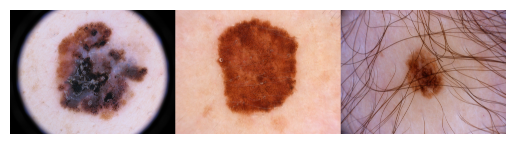

In [ ]:
img4, img7, img19 = cv2.imread('data/images_test/img4.jpg'), cv2.imread('data/images_test/img7.jpg'), cv2.imread('data/images_test/img19.jpg')
view3imgs(img4, img7, img19)

### Pipeline Organization

The pipeline implemented to obtain binary segmentation masks of skin lesions is divided into three distinct parts: pre-processing, segmentation, and post-processing.

#### Pre-processing:

The pre-processing steps aim to "clean" the original image to improve the quality of the output from the segmentation algorithm that will subsequently be applied to the dermatological image. Two sub-steps are distinguished in this image pre-treatment: _black frame removal_ and _hair removal_.

Indeed, some images present dark or black areas in the corners that interfere with the _hair removal_ and segmentation algorithms. The first challenge is therefore to select these black areas, the black frames, so as not to take them into account in the subsequent processing within the pipeline.

Next, we seek to remove potential hair present on the images because they are dark and strongly interfere with the lesions, which are also dark.


#### Otsu's Segmentation Method:

To better understand why pre-processing is essential, it is first necessary to focus on the segmentation method we used. This is Otsu's segmentation method, which allows binary segmentation between 2 classes (distinct parts of the image) and is based on maximizing the inter-class variance. A certain grayscale threshold is set, then by defining the variance of each class and then the inter-class variance, we look for the threshold that will maximize this latter variance. We can then apply binary thresholding to the image to obtain a binary mask. Due to this binarization by searching for a threshold to separate the image into two parts, we notice that the impact of hair and _black frames_ is very important because they interfere during the definition of the two classes which initially should be the skin (class C0) and the lesion (class C1).

## Otsu Segmentation:

To realize the interest of the entire pipeline, we first focus on our segmentation method alone, Otsu. As already mentioned previously, it is based on the definition of two classes using a grayscale threshold that maximizes the inter-class variance. Otsu segmentation is developed in the `otsu_seg.py` module. For Otsu's method, we convert the starting image to grayscale with the `cvtColor` function and its `cv2.COLOR_BGR2GRAY` attribute from the `cv2` module.

First, we calculate the histogram of the image with `calcHist` from `cv2`. Then, we normalize the histogram to obtain the probability of occurrence of each gray level, with the `prob_gray_lvl` function. We are then able to calculate the probability of each class and its mean as a function of threshold t, and finally the inter-class variance still as a function of t using the `var_between_class` function. It is this variance that we maximize in the `otsu` function which provides the corresponding threshold. It is with this threshold value that we apply binary thresholding afterwards.

```python 
def otsu(img,mask):
    var_max = 0
    tresh = 0
    for i in range(N):
        var = var_between_class(img,mask,i)
        if var > var_max:
            var_max = var
            tresh = i
    return tresh
```
However, we notice that while Otsu's segmentation method works well for "clean" images with good contrast and a clear skin lesion, without hair and without black edges, this is not the case for all other lesion images. Indeed, for clean images, we obtain a good Dice score close to 1 (cf. image 7 with a dice of 0.98). On the other hand, if the image contains black frames, they are found in the binary mask produced by Otsu which automatically lowers the dice score (cf. image 1 with a dice of 0.51 or image 19 with a dice of 0.42). Below are the respective binary masks of images 1, 7 and 19 obtained by Otsu alone:

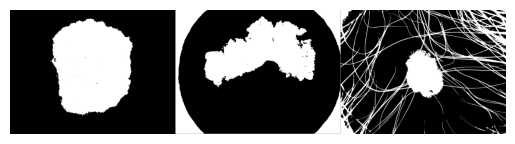

In [ ]:
img1 , img7, img19 = cv2.cvtColor(cv2.imread('data/images_test/img1.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('data/images_test/img7.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('data/images_test/img19.jpg'), cv2.COLOR_BGR2GRAY)
res1, res7, res19 = display_otsu_simple(img1), display_otsu_simple(img7), display_otsu_simple(img19)
view3imgs(res7, res1, res19)

Now that the need for pre-treatment on our images is clear, it is important to show the necessity of post-processing to be able to obtain the best possible lesion masks. Indeed, even if the segmentation is already satisfactory in the case of images without hair and without black edges, we realize that the lesion mask (white part) is not uniform. Post-processing methods must be applied to remedy these undesirable artifacts of Otsu segmentation. Below are examples of these undesirable artifacts on masks already satisfactory after the first two steps of the pipeline (cf. image 5 and image 6):

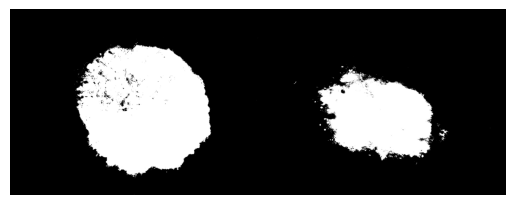

In [ ]:
img5, img6 = cv2.cvtColor(cv2.imread('data/images_test/img5.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('data/images_test/img6.jpg'), cv2.COLOR_BGR2GRAY)
res5, res6 = display_otsu_simple(img5), display_otsu_simple(img6)
viewimgs(res5, res6)

## Pre-processing:

### Black frames removal:

In this part of pre-processing, we focus on images that present black edges or dark areas that must be "removed" or at least identified so as not to be taken into account in the rest of the pipeline. To select these undesirable areas of the image, we work by _region growing_.

In the four corners of the image, we check on four sets of square pixels (whose size and position are parameters) that there are black areas. To verify that these sets of pixels are black, we calculate their average and compare this value to a certain _tau_ (threshold which is also a parameter of the pipeline). After several trials and to properly remove all black areas, even diffuse ones, we set the **threshold at 150**. If the image does not have black areas then this step is not necessary and we therefore return the original image to continue the pipeline. On the other hand, if we find black sets in the corners of the image, we start the _region growing_ process. From each set of pixels, we initialize a waiting list of black pixels to visit and a list gathering all the coordinates of black pixels that have already been visited. By traversing each neighbor of each identified black pixel, always defined as pixels below a certain threshold _tau_, we can then gather progressively all the undesirable black pixels located on the edges of our image.


Once all the black pixels on the edges of our image have been visited, their coordinates are returned in the form of a mask that will allow them not to be taken into account in the other steps of the pipeline. This mask is returned by the `mask_remove` function from the `blk_removal.py` module. The pixels not to be taken into account are marked as **False** and the pixels to be taken into account (which constitute the part of the image to study) are marked as **True**.

By applying _black frame removal_ we obtain a better segmentation mask of the skin lesion. Below is the original grayscale image and the masks obtained respectively with simple segmentation and with pre-processing before segmentation (for image 4):

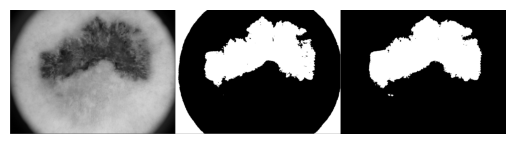

In [ ]:
img4 = cv2.cvtColor(cv2.imread('data/images_test/img1.jpg'), cv2.COLOR_BGR2GRAY)
tau,l,x,y = 150,5,10,10 
res4, res4_prime = display_otsu_simple(img4), display_otsu_prepro1(img4,tau,l,x,y)
tau,l,x,y = 150,5,10,10
view3imgs(img4, res4, res4_prime)

### Dull razor:

In this part of pre-processing, we focus on the _hair remover_ part which consists of removing hair from the photo. We start by applying a Gaussian filter to the RGB image to partially blur the melanoma and avoid losing too much of its texture at the output of `dull_razor`. Next, we apply morphological closing on the red, green and blue channels successively, with lines of 0°, 90°, 45° and 135° as structuring element, to try to find a maximum of hair directions in the image. We subtract this last image from the initial image of each channel to obtain the mask by choosing at each step the maximum (maximum for directions in each separate color channel and maximum in the color channels for the final mask). This mask will therefore be our reference when we apply the inpaint function from openCV to the initial unblurred image.

The results obtained are satisfactory, but we observe a loss of information at the melanoma level. For this reason, we offer the clinician an option through which he/she chooses whether or not to remove the hair.

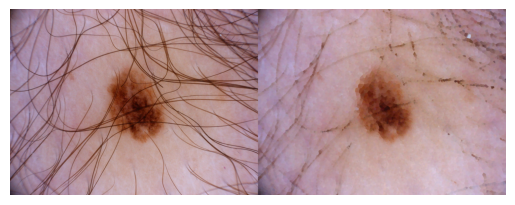

In [ ]:
img1 = 'data/images_test/img19.jpg'
img1_d = dull_razor(img1)
viewimgs(cv2.imread(img1), img1_d)

## Post-processing:

For the last step of the pipeline, it is a matter of smoothing the result obtained after pre-processing and Otsu segmentation to retrieve as a mask only the lesion in the form of a single connected component.

To fill in the undesirable holes in our image, we use the morphological math tools included in the `skimage.morphology` library. This step applies an opening with a disk structuring element whose size is to be determined in order to obtain an optimal result. After numerous trials, this parameter is set at **20 pixels**. The opening allows filling the black holes of the lesion in the binary mask while preserving the initial shape of the image. Indeed, opening is a closing followed by a dilation by the same structuring element, here the disk.

Once this hole cleaning step is completed, it remains to keep only a single connected component for the lesion mask. To do this, we look for connected components in our mask and we keep the largest one. This step is performed by the `find_largest_connected_component` function from the `find_central_component.py` module. We are thus able to display a single mask for the lesion. While this improves the Dice in many cases, the search for the main connected component is not optimal if Otsu segmentation has separated the lesion mask into two distinct parts, as in the case of image 9. Below is image 9 with simple segmentation that separates the lesion and the mask after opening and searching for the largest connected component:

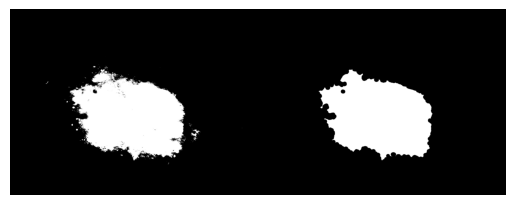

In [ ]:
i=20
img9, mask9= cv2.cvtColor(cv2.imread('data/images_test/img6.jpg'), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread('data/images_test/msk6.png'), cv2.COLOR_BGR2GRAY)
res9, res9_prime = display_otsu_prepro1(img9,tau,l,x,y), find_largest_connected_component(display_otsu_prepro1(opening(img9,morph.disk(i)),tau,l,x,y))
viewimgs(res9, res9_prime)

In [8]:
table_score(D)

/Users/louis/Documents/Telecom/2A/IMA/ProjIMA/4im01-skinlesions-giordmainabonniniere/test_otsu_postpro1.py:17: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  struct_element2 = morph.rectangle(j, k)
/Users/louis/Documents/Telecom/2A/IMA/ProjIMA/4im01-skinlesions-giordmainabonniniere/test_otsu_full.py:14: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  struct_element2 = morph.rectangle(j, k)


KeyboardInterrupt: 

### Improvement attempt: Otsu_level

We notice that all the steps of our pipeline allow increasing the Dice of our binary mask. However, for certain images, particularly with lesions having color levels, we notice that simple Otsu is limited and does not allow complete segmentation. Sometimes the lesion mask is truncated or cut in two (cf. images 9 and 10 respectively). To remedy this problem and improve the Dice scores overall, we can adapt the simple Otsu method operating on a grayscale image to color images. This operation is performed in the `display_otsu_level` function of the `otsu2.py` module. To do this, we can decompose the color image into four sub-images: grayscale image, red channel image, blue channel image and green channel image. Then, we apply the previously described pipeline (pre-processing, simple Otsu and post_processing) to each of these four images. We obtain four masks that we superimpose (cf. union of all binary masks) to obtain the final mask. This allows maximizing the contrasts on different color channels in order to improve the final mask.

However, the result is disappointing because the overall results are of lower quality than for the simple Otsu method.

In [ ]:
table_score_lvl(D_lvl)

| Image | Otsu_level 
| --- | --- 
| Image 1 | 0.6378458282510885 |
| Image 2 | 0.8932540981193757 |
| Image 3 | 0.6108226427918181 |
| Image 4 | 0.8609189296328632 |
| Image 5 | 0.8640363785467936 |
| Image 6 | 0.7090195188839923 |
| Image 7 | 0.9883241448143872 |
| Image 8 | 0.8873684074643728 |
| Image 9 | 0.7552158201718225 |
| Image 10 | 0.7669110718725504 |
| Image 11 | 0.9423174734279567 |
| Image 12 | 0.9694262638785072 |
| Image 13 | 0.9491522018643523 |
| Image 14 | 0.8908092275384032 |
| Image 15 | 0.5787929150953025 |
| Image 16 | 0.9009790254370363 |
| Image 17 | 0.8719948356465334 |
| Image 18 | 0.9816183059508811 |
| Image 19 | 0.0 |
| Image 20 | 0.6453185498813718 |


We can then improve the results obtained by Otsu's method by using 2 thresholds $t_h$ and $t_s$ to form a global threshold. The idea comes from the fact that with Otsu's method, we may have segmented on a part of the melanoma, and we would like the segmentation to be done properly on the skin.

To obtain the different thresholds, we must do a study on the characteristics of skin pixels. We choose a skin sample according to certain criteria on the mean and standard deviation and we calculate the intensity image; that is to say an image that we obtain by comparison with the median elements of the selected skin region.

For this, we want to maximize both the inter-class variance, but also the histogram of a set of regions chosen appropriately. The threshold in question will therefore be the first threshold: $t_h$. In this case we choose the window of the complete image and an area of diagonal pixels (forming a United Kingdom flag).

The other threshold $t_s$, is calculated using the 5th and 50th percentiles of the intensity image values. A constant beta weights the two values.

We then obtain: $t = \alpha \cdot t_h + (1 - \alpha) \cdot t_s$ with the constant alpha weighting the final threshold. And if $t_s > t_h$, which can be the case in the presence of too many artifacts, we set $\alpha = 1$, and thus the value of $t_s$ does not influence.
We then apply Otsu to the intensity image with this threshold.

We tried to implement this method, but we did not succeed in debugging the code...